In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
from carla_gym.core.obs_manager.birdview.Gaze import GazeDirection
import re
import seaborn as sns

import carla
import yaml
import os

from utils.server_utils import CarlaServerManager

In [2]:
def read_episode_stat_buffers(file_path):
    ep_stat_buf_names = [f for f in os.listdir(file_path) if 'ep_stat_buffer' in f]
    # read the json file
    data_df = pd.DataFrame()
    for f in ep_stat_buf_names:
        json_file_name = os.path.join(file_path, f)
        with open(json_file_name) as json_file:
            json_file = json.load(json_file)
            episode_dicts = json_file['hero']
            for json_file in episode_dicts:
                data_df = data_df.append(json_file, ignore_index=True)
    data_df['encounter_light'] = data_df['encounter_light'].astype(int)
    data_df['encounter_stop'] = data_df['encounter_stop'].astype(int)
    data_df['is_route_completed'] = data_df['is_route_completed'].astype(bool)
    data_df['is_route_completed_nocrash'] = data_df['is_route_completed_nocrash'].astype(bool)
    data_df['light_passed'] = data_df['light_passed'].astype(int)
    data_df['red_light'] = data_df['red_light'].astype(int)
    data_df = data_df.round(2)
    return data_df




def create_collisions_vehicle_df(file_path, df):
    accidents = df[df['is_route_completed_nocrash'] == False]
    ret = pd.DataFrame()
    for i in range(len(accidents)):
        row = accidents.iloc[i]
        suite = row['suite']
        run = row['run']
        file_name = os.path.join(file_path, 'diagnostics', suite, f"{run}.json")
        with open(file_name) as json_file:
            json_file = json.load(json_file)
            json_data = json_file['hero']
            collision_vehicle_info = json_data['collisions_vehicle']
            for collision_vehicle in collision_vehicle_info:
                collision_vehicle['suite'] = suite
                collision_vehicle['run'] = run
                for key in ['normal_impulse', 'event_loc', 'event_rot', 'ev_loc', 'ev_rot', 'ev_vel', 'oa_loc', 'oa_rot', 'oa_vel']:
                    collision_vehicle[f"{key}_x"], collision_vehicle[f"{key}_y"], collision_vehicle[f"{key}_z"] = collision_vehicle.pop(key)
                ret = pd.concat([ret, pd.DataFrame([collision_vehicle])], ignore_index=True)
    ret = ret.round(4)
    return ret

def get_veh_col_scenario_df_with_idx(file_path, df, index, threshold=50):
    row = df.iloc[index]
    suite, run, step, other_agent_id = row['suite'], row['run'], row['step'], row['other_actor_id']
    file_name = os.path.join(file_path, 'diagnostics', suite, f"{run}.csv")
    ego_df = pd.read_csv(file_name)
    ego_df = ego_df[(ego_df['timestamp'] >= step - threshold) & (ego_df['timestamp'] <= step + threshold)]
    ego_df['suite'] = suite
    ego_df['run'] = run
    ego_df['other_actor_id'] = other_agent_id
    # ego_df['perception_error'] = ego_df['perception_error'].apply(lambda x: 0 if x < 0 else x)
    return ego_df

def get_veh_col_scenario_df(file_path, df, threshold=50):
    n_row = len(df)
    ret = pd.DataFrame()
    for i in range(n_row):
        ego_df = get_veh_col_scenario_df_with_idx(file_path, df, i, threshold)
        ret = pd.concat([ret, ego_df], ignore_index=True)
    return ret

def plot_gaze_direction_distribution(df):
    # Map gaze_direction integers to labels
    gaze_labels = {}
    for gd in GazeDirection:
        gaze_labels[f"GazeDirection.{gd.name}"] = gd.value
    df['gaze_direction'] = df['gaze_direction'].map(gaze_labels)
    sns.set_theme(style="darkgrid")
    plt.figure(figsize=(12, 6))
    sns.histplot(df['gaze_direction'], bins=range(0, 8), discrete=True, stat='count', kde=False)
    plt.xlabel('Gaze Direction')
    plt.ylabel('Frequency')
    plt.title('Gaze Direction Distribution')
    plt.xticks(rotation=45)  

def plot_ego_df(ax, df, col_name):
    if 'gaze_direction' in col_name:
        gaze_labels = {}
        for gd in GazeDirection:
            gaze_labels[f"GazeDirection.{gd.name}"] = gd.value
        df['gaze_direction'] = df['gaze_direction'].map(gaze_labels)
        pass
    sns.set_theme(style="darkgrid")
    sns.lineplot(ax=ax, x='timestamp', y=col_name, data=df, marker='.', label=col_name)
    median_step = df['timestamp'].median()
    ax.axvline(x=median_step, color='r', linestyle='--', label='Median Step')
    ax.set_xlabel('Step')
    ax.set_ylabel('Value')
    ax.set_title(f'Step vs {col_name}')
    ax.legend()

def show_gaze_vs_error(df):
    fig, axs = plt.subplots(1, 2, figsize=(15, 3))  # Create a figure with 1 row and 2 columns of subplots
    plot_ego_df(axs[0], df, 'gaze_direction')
    plot_ego_df(axs[1], df, 'perception_error')
    plt.tight_layout()  # Adjust layout
    plt.show()

In [3]:
import time


def read_config(config_path):
    with open(config_path, 'r') as file:
        cfg = yaml.safe_load(file)
    return cfg

def init_client(host, port):
    try:
        client = carla.Client(host, port)
        print(f"client connected to {host}:{port}")
        print(f"client.get_server_version(): {client.get_server_version()}, client.get_client_version(): {client.get_client_version()}")
        client.set_timeout(60.0)
    except RuntimeError as re:
        if "timeout" not in str(re) and "time-out" not in str(re):
            print("Could not connect to Carla server because:", re)
        client = None 
    return client

# Assuming 'client' is already initialized and is an instance of carla.Client
# The path to your recorder log file

# def run_replay(config_path, recorder_file_path, start_time, duration, other_agent_id = 0):
#     cfg = read_config(config_path)
#     server_manager = CarlaServerManager(cfg['carla_sh_path'], cfg['port'], t_sleep=5)

#     server_manager.stop()
#     server_manager.start()
#     client = init_client(cfg['host'], cfg['port'])
#     # Check if file exists
#     try:
#         with open(recorder_file_path, 'r') as file:
#             print(f"File found: {recorder_file_path}")
#     except FileNotFoundError:
#         print(f"File not found: {recorder_file_path}")
#         exit()
#     try:
#         # Corrected call to replay_file
#         replay_result = client.replay_file(
#             recorder_file_path,
#             time_start=start_time,  # Explicitly specifying as double
#             duration=duration,    # Explicitly specifying as double
#             follow_id=other_agent_id,     # This is already an int, but making sure it's clearly specified
#             replay_sensors=True  # Assuming you want to replay sensors, adjust as necessary
#         )
#         print("Replaying recorded log file...")
#         time.sleep(duration+1)
#     except Exception as e:
#         print(f"An error occurred while trying to replay the file: {e}")

In [8]:
# file_path = r'C:\Users\abjawad\Documents\GitHub\carla-roach-0.9.13\outputs\2024-04-05\12-11-57' # basic 1
# file_path = r'C:\Users\abjawad\Documents\GitHub\carla-roach-0.9.13\outputs\2024-04-05\18-23-29' # basic 2

# file_path = r'C:\Users\abjawad\Documents\GitHub\carla-roach-0.9.13\outputs\2024-04-05\01-41-35' # equal
# file_path = r'C:\Users\abjawad\Documents\GitHub\carla-roach-0.9.13\outputs\2024-04-06\23-30-02' # equal

# file_path = r'C:\Users\abjawad\Documents\GitHub\carla-roach-0.9.13\outputs\2024-04-06\00-53-36' # gaussian
# file_path = r'C:\Users\abjawad\Documents\GitHub\carla-roach-0.9.13\outputs\2024-04-06\10-29-33' # gaussian

# file_path = r'C:\Users\abjawad\Documents\GitHub\carla-roach-0.9.13\outputs\2024-04-07\12-12-51' # strong memory equal
# file_path = r'C:\Users\abjawad\Documents\GitHub\carla-roach-0.9.13\outputs\2024-04-07\23-07-17' # strong memory gaussian


simulation_folder = {
    'basic1' : r'C:\Users\abjawad\Documents\GitHub\carla-roach-0.9.13\outputs\2024-04-05\12-11-57',
    'basic2' : r'C:\Users\abjawad\Documents\GitHub\carla-roach-0.9.13\outputs\2024-04-05\18-23-29',
    'equal1' : r'C:\Users\abjawad\Documents\GitHub\carla-roach-0.9.13\outputs\2024-04-05\01-41-35',
    'equal2' : r'C:\Users\abjawad\Documents\GitHub\carla-roach-0.9.13\outputs\2024-04-06\23-30-02',
    'gaussian1' : r'C:\Users\abjawad\Documents\GitHub\carla-roach-0.9.13\outputs\2024-04-06\00-53-36',
    'gaussian2' : r'C:\Users\abjawad\Documents\GitHub\carla-roach-0.9.13\outputs\2024-04-06\10-29-33',
    'strong_memory_equal1' : r'C:\Users\abjawad\Documents\GitHub\carla-roach-0.9.13\outputs\2024-04-07\12-12-51',
    'strong_memory_gaussian1' : r'C:\Users\abjawad\Documents\GitHub\carla-roach-0.9.13\outputs\2024-04-07\23-07-17' 
}

file_path = simulation_folder['basic1']

episode_stat_buff_df = read_episode_stat_buffers(file_path)
acc_episode = episode_stat_buff_df[episode_stat_buff_df['is_route_completed_nocrash'] == False] 

collisions_vehicle_df = create_collisions_vehicle_df(file_path, episode_stat_buff_df)
print("total collision ", len(collisions_vehicle_df))
accident_dfs = get_veh_col_scenario_df(file_path, collisions_vehicle_df, threshold=5)
# plot_gaze_direction_distribution(accident_dfs)
acc_episode.T

total collision  8


,2,5,6,8,9,11,19,21,22,24,26,36,39
collisions_layout,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
collisions_others,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
collisions_pedestrian,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
collisions_vehicle,1.57,0.0,0.55,0.0,0.68,0.0,0.4,0.0,0.0,0.0,0.95,0.95,0.0
encounter_light,7,2,10,7,4,5,13,1,10,3,14,6,6
encounter_stop,5,1,5,2,5,1,3,0,2,0,3,3,4
is_route_completed,True,False,True,False,True,False,True,False,False,False,True,True,False
is_route_completed_nocrash,False,False,False,False,False,False,False,False,False,False,False,False,False
length,3293.0,2756.0,7296.0,4646.0,3510.0,4248.0,8281.0,3606.0,4502.0,4501.0,8474.0,3504.0,4657.0
light_passed,7,1,10,7,4,5,13,1,10,3,14,6,6


KeyError: 'y'

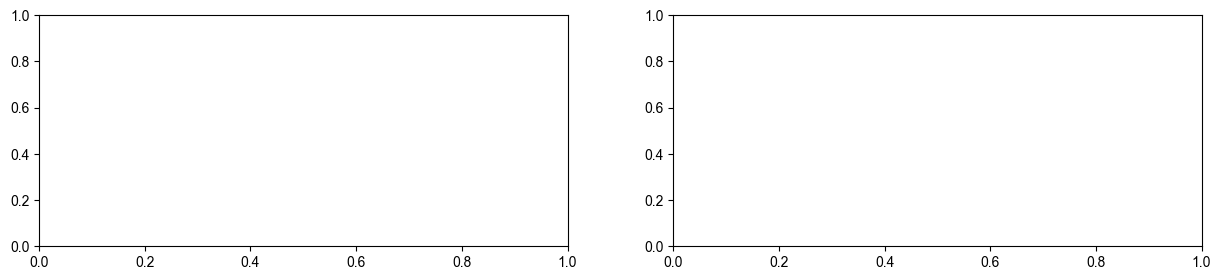

In [5]:
config_path = r'C:\Users\abjawad\Documents\GitHub\carla-roach-0.9.13\config\replay.yaml'


accident_index = 0
accident_df = get_veh_col_scenario_df_with_idx(file_path, collisions_vehicle_df, accident_index, threshold=25)
show_gaze_vs_error(accident_df)

suite = accident_df['suite'].iloc[0]
run = accident_df['run'].iloc[0]
other_actor_id = int(accident_df['other_actor_id'].iloc[0])
start_time = int(accident_df['timestamp'].min()/10)- 5

duration = 10
recorder_file_path = os.path.join(file_path, 'diagnostics', suite, f"{run}.log")
print(suite, run, start_time, duration, recorder_file_path)
